In [7]:
# Importation des bibliothèques nécessaires
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import cv2

In [8]:
# Montage de Google Drive pour accéder à la base de données
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os

# Chemin vers la base de données
data_dir = '/content/drive/MyDrive/Mask_Data'

# Liste des dossiers
folders = os.listdir(data_dir)

# Compter le nombre d'images dans chaque dossier
for folder in folders:
    print(f"Le dossier {folder} contient {len(os.listdir(os.path.join(data_dir, folder)))} images")


Le dossier with_mask contient 755 images
Le dossier without_mask contient 753 images


In [10]:
# Définition des paramètres
img_height, img_width = 224, 224  # Hauteur et largeur des images
batch_size = 32  # Taille des lots de données pour l'entraînement

# Augmentation des données
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Réduire l'intensité des pixels à une échelle de 0 à 1
    rotation_range=20,  # Rotation aléatoire des images jusqu'à 20 degrés
    width_shift_range=0.2,  # Déplacement horizontal aléatoire de l'image jusqu'à 20% de sa largeur
    height_shift_range=0.2,  # Déplacement vertical aléatoire de l'image jusqu'à 20% de sa hauteur
    shear_range=0.2,  # Inclinaison aléatoire de l'image
    zoom_range=0.2,  # Zoom aléatoire sur l'image
    horizontal_flip=True,  # Retournement horizontal aléatoire de l'image
    validation_split=0.20  # Fraction des données à utiliser pour la validation (20% dans ce cas)
)

# Création d'un générateur de données d'entraînement
train_generator = train_datagen.flow_from_directory(
    data_dir,  # Répertoire contenant les données d'entraînement
    target_size=(img_height, img_width),  # Redimensionnement des images à la taille spécifiée
    batch_size=batch_size,  # Taille des lots de données
    class_mode='categorical',  # Mode de classification catégorielle pour les étiquettes
    subset='training'  # Utiliser la sous-partie "training" des données
)

# Création d'un générateur de données de validation
validation_generator = train_datagen.flow_from_directory(
    data_dir,  # Répertoire contenant les données d'entraînement (les mêmes données que ci-dessus)
    target_size=(img_height, img_width),  # Redimensionnement des images à la taille spécifiée
    batch_size=batch_size,  # Taille des lots de données
    class_mode='categorical',  # Mode de classification catégorielle pour les étiquettes
    subset='validation'  # Utiliser la sous-partie "validation" des données
)


Found 1207 images belonging to 2 classes.
Found 301 images belonging to 2 classes.


# Chargement du VGG16

In [11]:
# Chargement d'un modèle pré-entraîné appelé VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Maintenant, nous ajoutons quelques éléments au modèle pour l'adapter à notre problème

# Étape 1 : On prend ce que le modèle VGG16 a trouvé dans l'image
x = base_model.output

# Étape 2 : On effectue une opération spéciale pour réduire les informations
# et rendre le modèle plus simple
x = GlobalAveragePooling2D()(x)

# Étape 3 : On ajoute une couche de calcul avec 1024 "aides" (neurones)
# pour mieux comprendre les images
x = Dense(1024, activation='relu')(x)

# Étape 4 : Enfin, on a deux choix possibles, et on demande au modèle
# de choisir entre eux en utilisant une méthode spéciale appelée "softmax"
predictions = Dense(2, activation='softmax')(x)

# Maintenant, nous avons une boîte complète avec toutes les instructions
# pour comprendre et prendre des décisions sur des images
model = Model(inputs=base_model.input, outputs=predictions)


58889256/58889256 [==============================] - 0s 0us/step


# Compilation du modele

In [12]:

# Compilation du modèle
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Définition de ModelCheckpoint pour sauvegarder le meilleur modèle
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

# Entraînement du modèle
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
38/38 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.8749

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 293s 7s/step - loss: 0.2737 - accuracy: 0.8749 - val_loss: 0.0178 - val_accuracy: 0.9900
Epoch 2/10
38/38 [==============================] - 29s 772ms/step - loss: 0.0277 - accuracy: 0.9884 - val_loss: 0.0180 - val_accuracy: 0.9934
Epoch 3/10
38/38 [==============================] - 30s 773ms/step - loss: 0.0082 - accuracy: 0.9983 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 4/10
38/38 [==============================] - 30s 778ms/step - loss: 0.0128 - accuracy: 0.9950 - val_loss: 0.0208 - val_accuracy: 0.9934
Epoch 5/10
38/38 [==============================] - 30s 778ms/step - loss: 0.0382 - accuracy: 0.9859 - val_loss: 0.2655 - val_accuracy: 0.9369
Epoch 6/10
38/38 [==============================] - 30s 772ms/step - loss: 0.0349 - accuracy: 0.9925 - val_loss: 0.0230 - val_accuracy: 0.9900
Epoch 7/10
38/38 [==============================] - 29s 767ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0276 - val_accuracy: 0.9934
Epoch 8/10
3

# Courbe d'accuracy

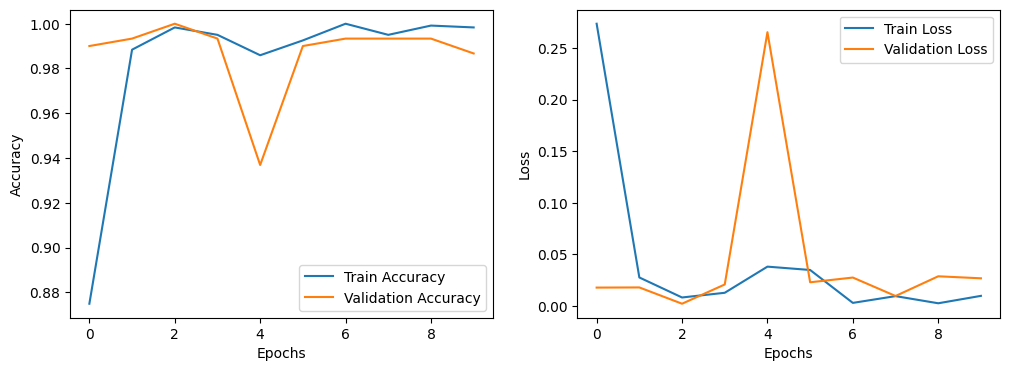

In [13]:
# Tracé des courbes d'accuracy et de loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Évaluation du modèle sur les données de test

In [14]:
# Importer la classe 'ImageDataGenerator' de la bibliothèque 'keras.preprocessing.image'
from keras.preprocessing.image import ImageDataGenerator

# Création d'un générateur de données de test
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Utilisation du générateur de données pour charger les images de test depuis un répertoire
test_generator = test_datagen.flow_from_directory(
    data_dir,  # Répertoire contenant les images de test
    target_size=(img_height, img_width),  # Redimensionnement des images à la taille spécifiée
    batch_size=batch_size,  # Taille des lots de données
    class_mode='categorical',  # Mode de classification catégorielle pour les étiquettes
    subset='training'  # Utilisation de la sous-partie "training" des données (dans le cas des données de test)
)

# Chargement des poids du modèle pré-entraîné depuis un fichier (poids déjà appris)
model.load_weights("best_model.h5")

# Évaluation des performances du modèle sur les données de test
test_loss, test_acc = model.evaluate(test_generator)

# Affichage de la précision du modèle sur les données de test
print(f"Précision sur les données de test : {test_acc}")


Found 1508 images belonging to 2 classes.
48/48 [==============================] - 9s 185ms/step - loss: 5.6406e-04 - accuracy: 1.0000
Test Accuracy: 1.0


# Matrice de confusion et rapport de classification

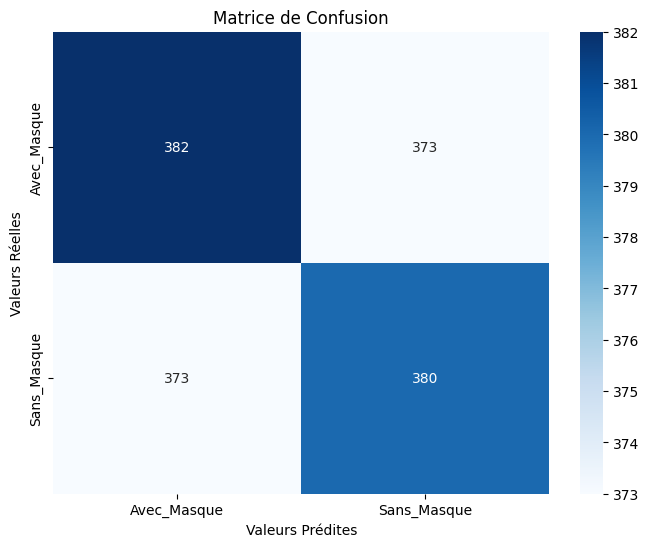

Rapport de Classification :
               precision    recall  f1-score   support

 Avec_Masque       0.51      0.51      0.51       755
 Sans_Masque       0.50      0.50      0.50       753

    accuracy                           0.51      1508
   macro avg       0.51      0.51      0.51      1508
weighted avg       0.51      0.51      0.51      1508



In [28]:


# Calcul de la matrice de confusion
confusion = confusion_matrix(test_generator.classes, y_pred)

# Définir les étiquettes de classe
class_names = ['Avec_Masque', 'Sans_Masque']

# Afficher la matrice de confusion sous forme de heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Valeurs Prédites')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()

# Afficher le rapport de classification
target_names = ['Avec_Masque', 'Sans_Masque']
report = classification_report(test_generator.classes, y_pred, target_names=target_names)
print("Rapport de Classification :\n", report)


In [16]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

# Définition d'une fonction pour prendre une photo à partir de la caméra
def take_photo(filename='photo.jpg', quality=0.8):
  # Le code JavaScript ci-dessous sera exécuté dans le navigateur

  # Création d'un élément div pour contenir les éléments
  const div = document.createElement('div');

  # Création d'un bouton appelé "Capture"
  const capture = document.createElement('button');
  capture.textContent = 'Capture';  # Texte du bouton
  div.appendChild(capture);  # Ajout du bouton au div

  # Création d'une zone vidéo pour afficher ce que la caméra voit
  const video = document.createElement('video');
  video.style.display = 'block';  # Affichage en bloc
  const stream = await navigator.mediaDevices.getUserMedia({video: true});  # Activation de la caméra
  document.body.appendChild(div);  # Ajout du div à la page
  div.appendChild(video);  # Ajout de la vidéo au div
  video.srcObject = stream;  # Connexion de la caméra à la vidéo
  await video.play();  # Démarrage de la vidéo

  # Ajustement de la taille de sortie pour correspondre à la taille de la vidéo
  google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

  # Attente que l'utilisateur clique sur le bouton "Capture"
  await new Promise((resolve) => capture.onclick = resolve);

  # Création d'un espace de dessin (canvas) pour l'image
  canvas = document.createElement('canvas');
  canvas.width = video.videoWidth;  # Largeur de la vidéo
  canvas.height = video.videoHeight;  # Hauteur de la vidéo

  # Dessin de l'image de la vidéo sur le canvas
  canvas.getContext('2d').drawImage(video, 0, 0);

  # Arrêt de la caméra et suppression des éléments de la page
  stream.getVideoTracks()[0].stop();
  div.remove();

  # Retourne les données de l'image sous forme de chaîne encodée en JPEG
  return canvas.toDataURL('image/jpeg', quality)

# Affichage du code JavaScript dans le notebook Colab
display(js)

# Exécution de la fonction JavaScript pour prendre la photo
data = eval_js('takePhoto({})'.format(quality))

# Décodage des données de l'image à partir de la chaîne encodée en base64
binary = b64decode(data.split(',')[1])

# Enregistrement de l'image dans un fichier
with open(filename, 'wb') as f:
  f.write(binary)

# Retour du nom du fichier dans lequel l'image a été enregistrée
return filename


<IPython.core.display.Javascript object>

Enregistrée sous photo.jpg


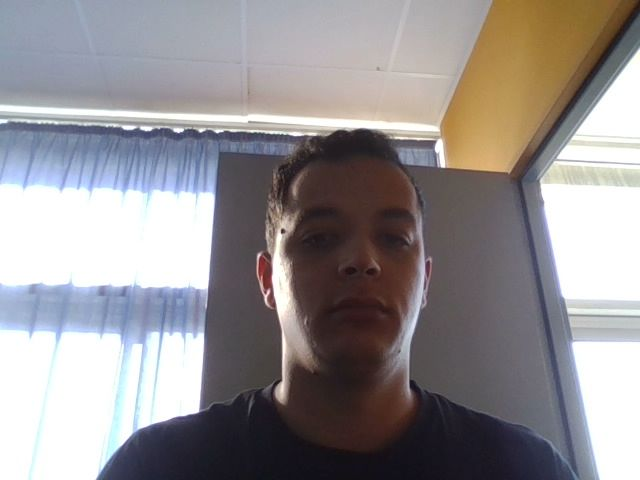

In [33]:
# Importer la classe 'Image' de la bibliothèque 'IPython.display'
from IPython.display import Image

# Essayer de prendre une photo
try:
  # Appeler la fonction 'take_photo' pour prendre une photo
  filename = take_photo()

  # Afficher un message indiquant où l'image a été enregistrée
  print('Enregistrée sous {}'.format(filename))

  # Afficher l'image qui vient d'être prise
  display(Image(filename))

# Gérer les erreurs
except Exception as err:
  # Si une erreur se produit (par exemple, si l'utilisateur n'a pas de webcam ou n'a pas autorisé l'accès à la webcam)
  # Imprimer le message d'erreur
  print(str(err))


1/1 [==============================] - 0s 189ms/step


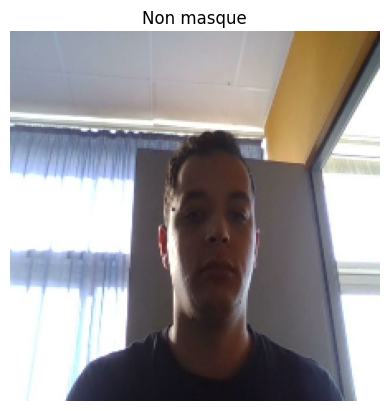

In [34]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Charger le modèle pré-entraîné
model = load_model("best_model.h5")

# Chargement de l'image
image = cv2.imread("photo.jpg")

# Redimensionner l'image à la taille attendue par le modèle (224x224 pixels)
image = cv2.resize(image, (224, 224))

# Reshape l'image pour qu'elle ait la forme attendue par le modèle (1, 224, 224, 3)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# Prédire la classe de l'image
predictions = model.predict(image)

# L'étiquette de classe prédite correspond à la classe avec la probabilité la plus élevée
predicted_class = np.argmax(predictions)

# Définir le message de prédiction
if predicted_class == 0:
    message = "Avec masque"
else:
    message = "Non masque"

# Afficher l'image avec le message
plt.imshow(cv2.cvtColor(image[0], cv2.COLOR_BGR2RGB))
plt.title(message)
plt.axis('off')  # Masquer les axes
plt.show()
